# Dataset Preview

### Notebook utilizado para pré visualização dos dados de exame

### Pacotes Utilizados:

In [ ]:
!pip install pyEDFlib
!pip install mne

In [8]:
import pyedflib
import numpy as np
import pandas as pd

def data_load(summary_model, selected_channels = []):

  try: 

    f = pyedflib.EdfReader("../data/" + summary_model.record_name + "/" + summary_model.file_name)
    
    if len(selected_channels) == 0:
      selected_channels = f.getSignalLabels()

    channel_names = f.getSignalLabels()
    channel_freq = f.getSampleFrequencies()

    sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
    for i, channel in enumerate(selected_channels):
      sigbufs[:, i] = f.readSignal(channel_names.index(channel))
    
    df = pd.DataFrame(sigbufs, columns = selected_channels).astype('float32')
    
    index_increase = np.linspace(0,
                                 len(df)/channel_freq[0],
                                 len(df), endpoint=False)

    seconds = np.floor(index_increase).astype('uint16')

    df['Time'] = seconds

    df = df.set_index('Time')

    df.columns.name = 'Channel'

    return df, channel_freq[0]

  except:
    OSError
    return pd.DataFrame(), None


In [9]:

import mne

def mne_object(data, freq, events = None):
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  data = data.apply(lambda x: x*1e-6)
  data_T = data.transpose()
  
  raw = mne.io.RawArray(data_T, info)

  if events:
    start_times = np.array(events[0])
    end_times = np.array(events[1])
    anno_length = end_times-start_times
    event_name = np.array(['Ictal']*len(anno_length))

    raw.set_annotations(mne.Annotations(start_times,
                                      anno_length,
                                      event_name))

  return raw

In [23]:
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'show_scrollbars': False,
    'show': True
}

chb01:(chb01_01.edf)
Creating RawArray with float64 data, n_channels=23, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


C:\Users\luiza\AppData\Local\Temp\ipykernel_23256\2975323691.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=list(data.columns),


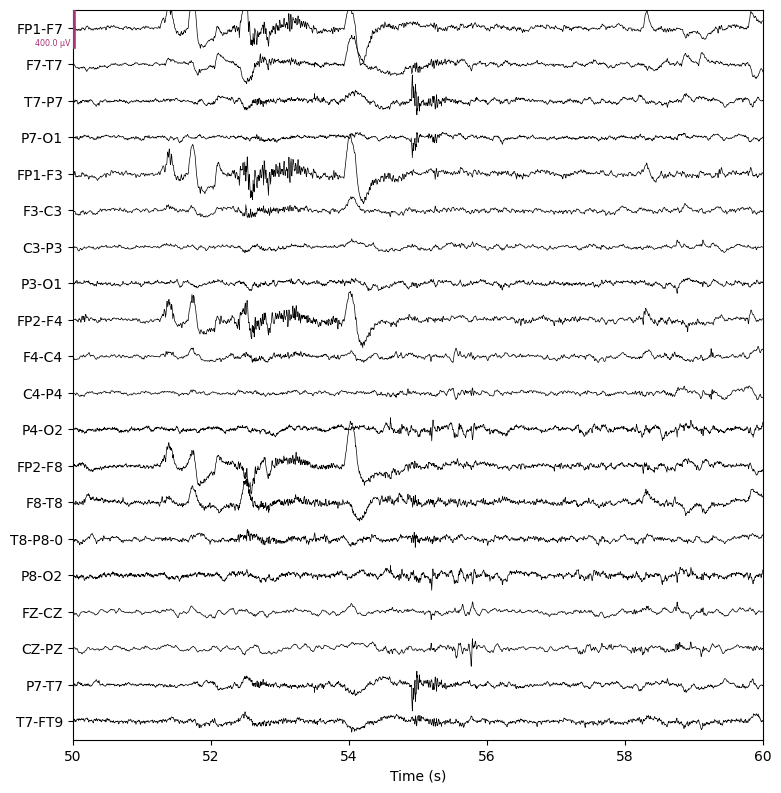

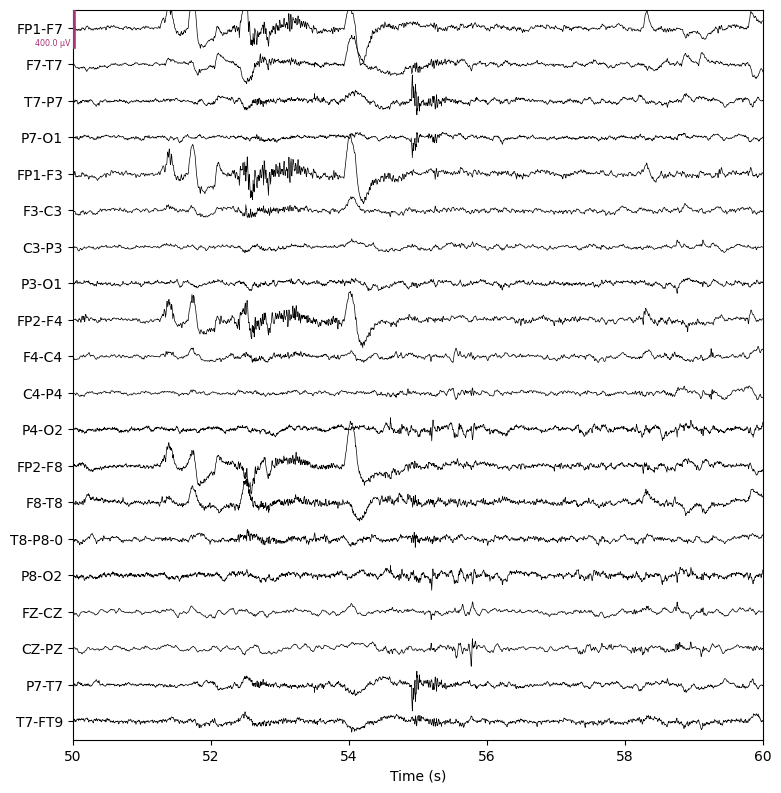

In [26]:
import database.databaseutils as db
import model.summarymodel as summary
import model.summarymodelconverter as converter

db.connect()

st = db.summary_by_name('chb01_01.edf')
summary_model = converter.model_from_tuple(st)

print(str(summary_model))

raw_data, freq = data_load(summary_model)

mne_data = mne_object(raw_data, freq)

mne_data.plot(start = 50, **plot_kwargs)